In [1]:
from datetime import datetime
import warnings
import nltk
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost
from scipy import stats
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import (
    Lasso,
    Ridge,
    ElasticNet,
    LinearRegression,
)
from sklearn.model_selection import ParameterGrid, train_test_split
from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
from tqdm import tqdm
from unidecode import unidecode
import shap
from TurkishStemmer import TurkishStemmer

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 20)

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
USE_BERT_EMBEDDINGS = False
TFIDF_ON = True
MAX_TFIDF_FEATURES = 1000
df = pd.read_pickle("all_tweets_v16.pkl")
df = df[df.tweet_type == "standard"]
df.head(3)

,author_id,context_annotations,conversation_id,created_at,edit_history_tweet_ids,id,in_reply_to_user_id,lang,possibly_sensitive,referenced_tweets,reply_settings,text,author,withheld,geo,quote_count,retweet_count,like_count,reply_count,impression_count,media_keys,poll_ids,hashtags,urls,mentions,cashtags,annotations,is_retweet,gender_of_author,profession_of_author,hashtags_flattened,trend_topics,n_trend_topics,text_length,has_media,has_hashtags,has_mentions,is_reply,tweet_type,ratio_like,ratio_retweet,majority_lang,english,universal,eng_astroturf,eng_fake_follower,eng_financial,eng_other,eng_overall,eng_self_declared,eng_spammer,uni_astroturf,uni_fake_follower,uni_financial,uni_other,uni_overall,uni_self_declared,uni_spammer,verified_author,followers_count_author,following_count_author,tweet_count_author,age_of_account_in_days_author,sentiment,created_at_day_of_week,created_at_month_of_year,created_at_time_of_day_in_seconds,reply_to_tweet_ratio,retweet_to_tweet_ratio,average_tweets_of_author_per_day,media_media_key_1,media_type_1,media_height_1,media_url_1,media_width_1,media_public_metrics_1,media_preview_image_url_1,media_duration_ms_1,media_alt_text_1,media_media_key_2,media_type_2,media_height_2,media_url_2,media_width_2,media_public_metrics_2,media_preview_image_url_2,media_duration_ms_2,media_alt_text_2,media_media_key_3,media_type_3,media_height_3,media_url_3,media_width_3,media_public_metrics_3,media_preview_image_url_3,media_duration_ms_3,media_alt_text_3,media_media_key_4,media_type_4,media_height_4,media_url_4,media_width_4,media_public_metrics_4,media_preview_image_url_4,media_duration_ms_4,media_alt_text_4,sttm_topic,political_context_annotation,created_at_year,created_at_time_of_day_in_seconds_sin,created_at_time_of_day_in_seconds_cos,n_media_keys,n_hashtags,n_urls,n_mentions,media_resolution_1,media_resolution_2,media_resolution_3,media_resolution_4,fear,anger,anticip,trust,surprise,positive,negative,sadness,disgust,joy,anticipation,translated_tweet,age_of_account_in_days_author_when_tweeted,posted_during_an_important_event,n_photos,n_videos,n_animated_gif,clean_text,word_count,new_lang,contains_digits,log_like_count,log_retweet_count,emojis,emoji_sentiment_score
0,1449804331142811655,[],1617597872803041280,2023-01-23 18:59:21,[1617597872803041280],1617597872803041280,NaN,tr,False,NaN,everyone,"Kararlarındaki temel dayanak, hukukun evrensel...",Goksun_KHK,NaN,NaN,0,2,1,0,82,NaN,NaN,"[{'start': 95, 'end': 120, 'tag': 'OhalKomisyo...",NaN,NaN,NaN,NaN,0,ORG,UNKNOWN,OhalKomisyonuHukuksuzdur,OhalKomisyonuHukuksuzdur,1,120,0,1,0,0,standard,0.012195,0.024390,tr,0.874858,0.847463,0.13,0.51,0.22,0.91,0.91,0.08,0.25,0.12,0.44,0.1,0.87,0.87,0.19,0.16,False,1107.0,174.0,2962.0,470.0,0.994189,0,1,68361,0.013817,0.435233,1.231915,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,search for justice,False,2023,-0.966656,0.256078,0.0,1,0,0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,The basic basis in their decisions is the demo...,463.0,0.0,0,0,0,"Kararlarındaki temel dayanak, hukukun evrensel...",11,tr,0,0.693147,1.098612,[],0.0
1,1449804331142811655,[],1617597646339702823,2023-01-23 18:58:27,[1617597646339702823],1617597646339702823,NaN,fr,False,NaN,everyone,#OhalKomisyonuHukuksuzdur https://t.co/3aUr5MZWPU,Goksun_KHK,NaN,NaN,0,1,0,0,52,[3_1617597636604723228],NaN,"[{'start': 0, 'end': 25, 'tag': 'OhalKomisyonu...","[{'start': 26, 'end': 49, 'url': 'https://t.co...",NaN,NaN,NaN,0,ORG,UNKNOWN,OhalKomisyonuHukuksuzdur,OhalKomisyonuHukuksuzdur,1,49,1,1,0,0,standard,0.000000,0.019231,tr,0.874858,0.847463,0.13,0.51,0.22,0.91,0.91,0.08,0.25,0.12,0.44,0.1,0.87,0.87,0.19,0.16,False,1107.0,174.0,2962.0,470.0,0.733746,0,1,68307,0.013817,0.435233,1.231915,3_1617597636604723228,photo,1600.0,https://pbs.twimg.com/media/FnLceudWABwBC4b.jpg,1600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [3]:
df.shape

(91102, 144)

# Preprocessing

## Column Types

In [4]:
irrelevant_columns = [
    "author_id",
    "conversation_id",
    "created_at",
    "edit_history_tweet_ids",
    "id",
    "in_reply_to_user_id",
    "referenced_tweets",
    "reply_settings",
    "quote_count",
    "impression_count",
    "media_keys",  # Incorporated via n_media_keys
    "hashtags",
    "has_hashtags",
    "has_mentions",
    "urls",
    "mentions",
    "cashtags",
    "is_retweet",
    "ratio_like",
    "ratio_retweet",
    "hashtags_flattened",
    "trend_topics",
    "has_media",  # incorporated with n_media
    "is_reply",
    "tweet_type",
    "created_at_day_of_week",  # incorporated by cyclic features
    "created_at_month_of_year",  # incorporated by cyclic features
    "created_at_time_of_day_in_seconds",  # Incorporated by cyclic features
    "media_media_key_1",  # Incorporated via n_media_keys
    "media_media_key_2",  # Incorporated via n_media_keys
    "media_media_key_3",  # Incorporated via n_media_keys
    "media_media_key_4",  # Incorporated via n_media_keys
    "media_height_1",  # incorporated by resolution feature
    "media_height_2",  # incorporated by resolution feature
    "media_height_3",  # incorporated by resolution feature
    "media_height_4",  # incorporated by resolution feature
    "media_width_1",  # incorporated by resolution feature
    "media_width_2",  # incorporated by resolution feature
    "media_width_3",  # incorporated by resolution feature
    "media_width_4",  # incorporated by resolution feature
    "media_resolution_1",
    "media_resolution_2",
    "media_resolution_3",
    "media_resolution_4",
    "media_public_metrics_1",
    "media_public_metrics_2",
    "media_public_metrics_3",
    "media_public_metrics_4",
    "media_duration_ms_1",
    "media_duration_ms_2",
    "media_duration_ms_3",
    "media_duration_ms_4",
    "media_type_1",
    "media_type_2",
    "media_type_3",
    "media_type_4",
    "age_of_account_in_days_author",  # incorporated by "age_of_account_in_days_author_when_tweeted"
    "translated_tweet",
    "majority_lang",  # incorporated via lang
    "lang",  # incorporated via new_lang
    "geo",  # not representative
    "poll_ids",  # not representative
]

additional_irrelevant_columns = [
    "author",  # incorporating it as a categorical variable doesn't add any value
    # Bot score features
    "english",
    "universal",
    "eng_astroturf",
    "eng_fake_follower",
    "eng_financial",
    "eng_other",
    "eng_overall",
    "eng_self_declared",
    "eng_spammer",
    "uni_astroturf",
    "uni_fake_follower",
    "uni_financial",
    "uni_other",
    "uni_overall",
    "uni_self_declared",
    "uni_spammer",
]

# These columns are not available at prediction time
descriptive_columns = [
    "context_annotations",
    "possibly_sensitive",
    "withheld",
    "annotations",
    "media_url_1",
    "media_url_2",
    "media_url_3",
    "media_url_4",
    "media_preview_image_url_1",
    "media_preview_image_url_2",
    "media_preview_image_url_3",
    "media_preview_image_url_4",
    "media_alt_text_1",
    "media_alt_text_2",
    "media_alt_text_3",
    "media_alt_text_4",
    "created_at_year",
]

categorical_columns = [
    "new_lang",
    "gender_of_author",
    "profession_of_author",
    "sttm_topic",
]

binary_columns = [
    "verified_author",
    "political_context_annotation",
    "posted_during_an_important_event",
]

target_columns = [
    "retweet_count",
    "like_count",
    "reply_count",
]

numerical_columns = [
    "n_trend_topics",
    "text_length",
    "followers_count_author",
    "following_count_author",
    "tweet_count_author",
    "age_of_account_in_days_author_when_tweeted",
    "sentiment",
    "reply_to_tweet_ratio",
    "retweet_to_tweet_ratio",
    "average_tweets_of_author_per_day",
    "created_at_time_of_day_in_seconds_sin",
    "created_at_time_of_day_in_seconds_cos",
    "n_media_keys",
    "n_hashtags",
    "n_urls",
    "n_mentions",
    # emotions
    "positive",
    "fear",
    "trust",
    "sadness",
    "anticip",
    "surprise",
    "disgust",
    "anger",
    "joy",
    "anticipation",
    "negative",
    # media features
    "n_photos",
    "n_videos",
    "n_animated_gif",
    "word_count",
]

In [5]:
all_columns = (
    irrelevant_columns
    + additional_irrelevant_columns
    + descriptive_columns
    + categorical_columns
    + binary_columns
    + target_columns
    + numerical_columns
)
for column_name in all_columns:
    assert all_columns.count(column_name) == 1
# assert set(all_columns) == set(df.columns), print(
#     set(all_columns).difference(set(df.columns)),
#     set(df.columns).difference(set(all_columns)),
# )

In [6]:
preprocessed_df = df.copy()
preprocessed_df.head()

,author_id,context_annotations,conversation_id,created_at,edit_history_tweet_ids,id,in_reply_to_user_id,lang,possibly_sensitive,referenced_tweets,reply_settings,text,author,withheld,geo,quote_count,retweet_count,like_count,reply_count,impression_count,media_keys,poll_ids,hashtags,urls,mentions,cashtags,annotations,is_retweet,gender_of_author,profession_of_author,hashtags_flattened,trend_topics,n_trend_topics,text_length,has_media,has_hashtags,has_mentions,is_reply,tweet_type,ratio_like,ratio_retweet,majority_lang,english,universal,eng_astroturf,eng_fake_follower,eng_financial,eng_other,eng_overall,eng_self_declared,eng_spammer,uni_astroturf,uni_fake_follower,uni_financial,uni_other,uni_overall,uni_self_declared,uni_spammer,verified_author,followers_count_author,following_count_author,tweet_count_author,age_of_account_in_days_author,sentiment,created_at_day_of_week,created_at_month_of_year,created_at_time_of_day_in_seconds,reply_to_tweet_ratio,retweet_to_tweet_ratio,average_tweets_of_author_per_day,media_media_key_1,media_type_1,media_height_1,media_url_1,media_width_1,media_public_metrics_1,media_preview_image_url_1,media_duration_ms_1,media_alt_text_1,media_media_key_2,media_type_2,media_height_2,media_url_2,media_width_2,media_public_metrics_2,media_preview_image_url_2,media_duration_ms_2,media_alt_text_2,media_media_key_3,media_type_3,media_height_3,media_url_3,media_width_3,media_public_metrics_3,media_preview_image_url_3,media_duration_ms_3,media_alt_text_3,media_media_key_4,media_type_4,media_height_4,media_url_4,media_width_4,media_public_metrics_4,media_preview_image_url_4,media_duration_ms_4,media_alt_text_4,sttm_topic,political_context_annotation,created_at_year,created_at_time_of_day_in_seconds_sin,created_at_time_of_day_in_seconds_cos,n_media_keys,n_hashtags,n_urls,n_mentions,media_resolution_1,media_resolution_2,media_resolution_3,media_resolution_4,fear,anger,anticip,trust,surprise,positive,negative,sadness,disgust,joy,anticipation,translated_tweet,age_of_account_in_days_author_when_tweeted,posted_during_an_important_event,n_photos,n_videos,n_animated_gif,clean_text,word_count,new_lang,contains_digits,log_like_count,log_retweet_count,emojis,emoji_sentiment_score
0,1449804331142811655,[],1617597872803041280,2023-01-23 18:59:21,[1617597872803041280],1617597872803041280,NaN,tr,False,NaN,everyone,"Kararlarındaki temel dayanak, hukukun evrensel...",Goksun_KHK,NaN,NaN,0,2,1,0,82,NaN,NaN,"[{'start': 95, 'end': 120, 'tag': 'OhalKomisyo...",NaN,NaN,NaN,NaN,0,ORG,UNKNOWN,OhalKomisyonuHukuksuzdur,OhalKomisyonuHukuksuzdur,1,120,0,1,0,0,standard,0.012195,0.024390,tr,0.874858,0.847463,0.13,0.51,0.22,0.91,0.91,0.08,0.25,0.12,0.44,0.1,0.87,0.87,0.19,0.16,False,1107.0,174.0,2962.0,470.0,0.994189,0,1,68361,0.013817,0.435233,1.231915,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,search for justice,False,2023,-0.966656,0.256078,0.0,1,0,0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,The basic basis in their decisions is the demo...,463.0,0.0,0,0,0,"Kararlarındaki temel dayanak, hukukun evrensel...",11,tr,0,0.693147,1.098612,[],0.0
1,1449804331142811655,[],1617597646339702823,2023-01-23 18:58:27,[1617597646339702823],1617597646339702823,NaN,fr,False,NaN,everyone,#OhalKomisyonuHukuksuzdur https://t.co/3aUr5MZWPU,Goksun_KHK,NaN,NaN,0,1,0,0,52,[3_1617597636604723228],NaN,"[{'start': 0, 'end': 25, 'tag': 'OhalKomisyonu...","[{'start': 26, 'end': 49, 'url': 'https://t.co...",NaN,NaN,NaN,0,ORG,UNKNOWN,OhalKomisyonuHukuksuzdur,OhalKomisyonuHukuksuzdur,1,49,1,1,0,0,standard,0.000000,0.019231,tr,0.874858,0.847463,0.13,0.51,0.22,0.91,0.91,0.08,0.25,0.12,0.44,0.1,0.87,0.87,0.19,0.16,False,1107.0,174.0,2962.0,470.0,0.733746,0,1,68307,0.013817,0.435233,1.231915,3_1617597636604723228,photo,1600.0,https://pbs.twimg.com/media/FnLceudWABwBC4b.jpg,1600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [7]:
sentence_embedding_cols = [
    c for c in preprocessed_df.columns if c.startswith("sentence_embedding")
]
if USE_BERT_EMBEDDINGS:

    preprocessed_df.loc[preprocessed_df.new_lang != "tr", sentence_embedding_cols] = 0
else:
    preprocessed_df.drop(columns=sentence_embedding_cols, inplace=True)

In [8]:
def filter_n_values(data, col, threshold=10, other="other"):
    freq = data[col].value_counts().head(threshold).index.tolist()
    data[col] = np.where(data[col].isin(freq), data[col], other)
    return data


preprocessed_df = filter_n_values(preprocessed_df, "lang")

preprocessed_df["profession_of_author"] = np.where(
    preprocessed_df["profession_of_author"].isin(
        ["POLITICIAN", "LAWYER", "JOURNALIST"]
    ),
    preprocessed_df["profession_of_author"],
    "UNKNOWN",
)

preprocessed_df = filter_n_values(preprocessed_df, "sttm_topic", threshold=20)

In [9]:
authors = preprocessed_df.author.copy()
preprocessed_df = pd.get_dummies(preprocessed_df, columns=categorical_columns)
preprocessed_df["author"] = authors
# Impute columns with 0
media_columns_to_input = [
    f"{prefix}_{i}"
    for i in range(1, 5)
    for prefix in ["media_resolution", "media_duration_ms"]
]
for column in [
    "sentiment",
    "reply_to_tweet_ratio",
    "n_media_keys",
    "positive",
    "fear",
    "trust",
    "sadness",
    "anticip",
    "surprise",
    "disgust",
    "anger",
    "joy",
    "anticipation",
    "negative",
] + media_columns_to_input:
    preprocessed_df[column].fillna(0, inplace=True)

In [10]:
train_df, validation_df, test_df = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
for author in tqdm(preprocessed_df.author.unique()):
    author_df = preprocessed_df[preprocessed_df.author == author].copy()
    author_df.sort_values(by="created_at", inplace=True)
    n_train = int(author_df.shape[0] * 0.8)
    n_validation = int(author_df.shape[0] * 0.1)

    train_df = pd.concat([train_df, author_df.iloc[:n_train].copy()], ignore_index=True)
    validation_df = pd.concat(
        [validation_df, author_df.iloc[n_train : (n_train + n_validation)].copy()],
        ignore_index=True,
    )
    test_df = pd.concat(
        [test_df, author_df.iloc[(n_train + n_validation) :].copy()], ignore_index=True
    )

train_validation_df = pd.concat([train_df, validation_df], ignore_index=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 199/199 [00:14<00:00, 13.41it/s]


In [11]:
train_df.shape, validation_df.shape, train_validation_df.shape, test_df.shape

((72800, 171), (9028, 171), (81828, 171), (9274, 171))

In [12]:
for dataset in [train_df, validation_df, train_validation_df, test_df]:
    dataset.drop(columns=irrelevant_columns, inplace=True)
    dataset.drop(columns=descriptive_columns, inplace=True)
    dataset.drop(columns=additional_irrelevant_columns, inplace=True)

In [13]:
# Columns with missing values. This is a simple test and it shouldn't print anything
for dataset in [train_df, validation_df, train_validation_df, test_df]:
    for i in dataset[dataset.isna().any(axis=1)].isna().any().items():
        if i[1]:
            print(i[0])

In [14]:
def get_stopwords(lang):
    stopwords = nltk.corpus.stopwords.words(lang)
    return [unidecode(i) for i in stopwords]


def preprocess_tweet_text(row):
    if row.new_lang_en:
        stopwords = stopwords_by_lang["en"]
        stemmer = stemmer_by_lang["en"]

    elif row.new_lang_tr:
        stopwords = stopwords_by_lang["tr"]
        stemmer = stemmer_by_lang["tr"]

    else:
        return row.clean_text
    return " ".join(
        [stemmer.stem(w) for w in row.clean_text.split() if w not in stopwords]
    )


def create_tfidf_features(dataset_df, vectorizer=None, max_features=1000):
    dataset_df["text_preprocessed"] = dataset_df.apply(preprocess_tweet_text, axis=1)
    all_tweet_texts = dataset_df.text_preprocessed.to_list()

    if vectorizer:
        sparse_tfidf_features = vectorizer.transform(all_tweet_texts)
    else:
        vectorizer = TfidfVectorizer(max_features=max_features)
        sparse_tfidf_features = vectorizer.fit_transform(all_tweet_texts)

    tfidf_df = pd.DataFrame.sparse.from_spmatrix(
        sparse_tfidf_features, columns=vectorizer.get_feature_names_out()
    )
    return pd.concat([dataset_df, tfidf_df], axis=1), vectorizer


if not USE_BERT_EMBEDDINGS and TFIDF_ON:
    stopwords_by_lang = {
        "tr": get_stopwords("turkish"),
        "fr": get_stopwords("french"),
        "en": get_stopwords("english"),
    }
    stemmer_by_lang = {
        "tr": TurkishStemmer(),
        "fr": nltk.stem.SnowballStemmer("french"),
        "en": nltk.stem.SnowballStemmer("english"),
    }

    train_df["text_preprocessed"] = train_df.apply(preprocess_tweet_text, axis=1)
    validation_df["text_preprocessed"] = validation_df.apply(
        preprocess_tweet_text, axis=1
    )
    train_validation_df["text_preprocessed"] = train_validation_df.apply(
        preprocess_tweet_text, axis=1
    )
    test_df["text_preprocessed"] = test_df.apply(preprocess_tweet_text, axis=1)
    
    train_df, vectorizer = create_tfidf_features(
        train_df, max_features=MAX_TFIDF_FEATURES
    )
    validation_df, _ = create_tfidf_features(
        validation_df, vectorizer, max_features=MAX_TFIDF_FEATURES
    )

    train_validation_df, train_validation_vectorizer = create_tfidf_features(
        train_validation_df, max_features=MAX_TFIDF_FEATURES
    )
    test_df, _ = create_tfidf_features(
        test_df, train_validation_vectorizer, max_features=MAX_TFIDF_FEATURES
    )

In [15]:
def calculate_metrics(y_true, y_predicted):
    mae = metrics.mean_absolute_error(y_true, y_predicted)
    rmse = metrics.mean_squared_error(y_true, y_predicted, squared=False)
    r2 = metrics.r2_score(y_true, y_predicted)
    return mae, rmse, r2


def back_transform_predictions(y_predicted, target_column, box_cox_lambda):
    if target_column in ["log_retweet_count", "log_retweet_count"]:
        y_predicted = np.exp(y_predicted)
    elif target_column in ["box_cox_retweet_count", "box_cox_retweet_count"]:
        y_predicted = (y_predicted * box_cox_lambda + 1) ** (1 / box_cox_lambda)
    elif target_column in ["square_root_retweet_count", "square_root_retweet_count"]:
        y_predicted = y_predicted**2
    return y_predicted


def evaluate(
    model,
    model_name,
    x,
    y_true,
    dataset_name,
    target_column,
    box_cox_lambda,
    silent=False,
):
    print("Predicting with the trained model")

    y_predicted = model.predict(x)
    y_predicted = back_transform_predictions(y_predicted, target_column, box_cox_lambda)
    try:
        mae, rmse, r2 = calculate_metrics(y_true, y_predicted)
    except ValueError as e:
        print(f"Error happened due to nan values: {e}")
        return np.inf, np.inf, 0
    if not silent:
        print(f"The {model_name} model performance for {dataset_name} set")
        print("--------------------------------------")
        print(f"MAE is {mae}")
        print(f"RMSE is {rmse}")
        print(f"R2 score is {r2}\n\n")
    return mae, rmse, r2


def fine_tune_model(param_grid, model_class, model_name, box_cox_lambda):
    model = model_class()
    best_r2 = 0
    best_params = None
    best_model = None
    for params in param_grid:
        target_column = params["target_column"]
        # print(f"\n\nTraining {model_name} with params: {params}...\n\n")
        model.set_params(**{k: v for k, v in params.items() if k != "target_column"})
        model.fit(x_train, y_train[target_column])

        mae, rmse, r2 = evaluate(
            model,
            model_name,
            x_validation,
            y_validation.like_count,
            "validation",
            target_column,
            box_cox_lambda,
            True,
        )
        if r2 > best_r2:
            best_r2 = r2
            best_params = params
            best_model = model
    print(f"Found best params: {best_params}")
    return best_params


def train_best_model(model_class, best_params):
    target_column = best_params["target_column"]
    model = model_class(
        **{k: v for k, v in best_params.items() if k != "target_column"}
    )
    model.fit(x_train_validation, y_train_validation[target_column])
    return model


def evaluate_best_model(model_name, model, target_column):
    mae, rmse, r2 = evaluate(
        model,
        model_name,
        x_train_validation,
        y_train_validation.retweet_count,
        "train_validation",
        target_column,
        train_validation_box_cox_lambda,
        True,
    )
    mae, rmse, r2 = evaluate(
        model,
        model_name,
        x_test,
        y_test.retweet_count,
        "test",
        target_column,
        train_validation_box_cox_lambda,
        True,
    )
    return {"model_name": model_name, "mae": mae, "rmse": rmse, "r2": r2}

In [16]:
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

last_irrelevant_columns = ["text", "text_preprocessed", "clean_text"]


def split_x_and_y(input_df):
    x = input_df[
        [
            c
            for c in input_df.columns
            if c not in target_columns + last_irrelevant_columns
        ]
    ].copy()
    y = input_df[[c for c in input_df.columns if c in target_columns]].copy()
    return x, y


def add_additional_target_colummns(
    y: pd.DataFrame, box_cox_lambda: float = None
) -> tuple[pd.DataFrame, float]:
    y["log_retweet_count"] = y.retweet_count.apply(lambda x: np.log(max(1, x)))
    if box_cox_lambda is None:
        print("Calculating lambda value for box-cox...")
        y["box_cox_retweet_count"], box_cox_lambda = stats.boxcox(
            y.retweet_count.apply(lambda x: max(1, x))
        )
    else:
        y["box_cox_retweet_count"] = stats.boxcox(
            y.retweet_count.apply(lambda x: max(1, x)), box_cox_lambda
        )
    y["square_root_retweet_count"] = y.retweet_count.apply(np.sqrt)
    return y, box_cox_lambda


def scale_features(x, scaler=None):
    if scaler is None:
        scaler = StandardScaler(copy=True)
        scaler.fit(x)
    return scaler.transform(x), scaler


x_train, y_train = split_x_and_y(train_df)
x_validation, y_validation = split_x_and_y(validation_df)
x_train_validation, y_train_validation = split_x_and_y(train_validation_df)
x_test, y_test = split_x_and_y(test_df)

y_train, box_cox_lambda = add_additional_target_colummns(y_train)
y_validation, _ = add_additional_target_colummns(y_validation, box_cox_lambda)
y_train_validation, train_validation_box_cox_lambda = add_additional_target_colummns(
    y_train_validation
)
y_test, _ = add_additional_target_colummns(y_test, train_validation_box_cox_lambda)


# x_train, scaler = scale_features(x_train)
# x_validation, _ = scale_features(x_validation, scaler)
# x_train_validation, train_validation_scaler = scale_features(x_train_validation)
# x_test, _ = scale_features(x_test, train_validation_scaler)

Calculating lambda value for box-cox...
Calculating lambda value for box-cox...


In [17]:
RANDOM_STATE = 0

elastic_net_param_grid = ParameterGrid(
    {
        "random_state": [RANDOM_STATE],
        "l1_ratio": [0.001, 0.01, 0.1],
        "max_iter": [1000],
        "copy_X": [True],
        "selection": ["random"],
        "target_column": [
            "square_root_retweet_count",
            "box_cox_retweet_count",
            "retweet_count",
            "log_retweet_count",
        ],
    }
)
# elastic_net_best_params = fine_tune_model(
#     elastic_net_param_grid, ElasticNet, "ElasticNet", box_cox_lambda
# )

elastic_net_best_params = {
    "copy_X": True,
    "l1_ratio": 0.7,
    "max_iter": 1000,
    "random_state": 0,
    "selection": "random",
    "target_column": "retweet_count",
}

linear_regression_param_grid = ParameterGrid(
    {
        "copy_X": [True],
        "n_jobs": [-1],
        "target_column": [
            "square_root_retweet_count",
            "box_cox_retweet_count",
            "retweet_count",
            "log_retweet_count",
        ],
    }
)
# linear_regression_best_params = fine_tune_model(
#     linear_regression_param_grid, LinearRegression, "LinearRegression", box_cox_lambda
# )
linear_regression_best_params = {
    "copy_X": True,
    "n_jobs": -1,
    "target_column": "square_root_retweet_count",
}


lasso_param_grid = ParameterGrid(
    {
        "copy_X": [True],
        "alpha": [0.001, 0.01, 0.1],
        "max_iter": [1000],
        "random_state": [RANDOM_STATE],
        "target_column": [
            "square_root_retweet_count",
            "box_cox_retweet_count",
            "retweet_count",
            "log_retweet_count",
        ],
    }
)
# lasso_best_params = fine_tune_model(lasso_param_grid, Lasso, "Lasso", box_cox_lambda)
lasso_best_params = {
    "alpha": 1.5,
    "copy_X": True,
    "max_iter": 1000,
    "random_state": 0,
    "target_column": "retweet_count",
}


ridge_param_grid = ParameterGrid(
    {
        "copy_X": [True],
        "alpha": [0.001, 0.01, 0.1],
        "random_state": [RANDOM_STATE],
        "solver": ["svd", "cholesky", "lsqr", "sparse_cg"],
        "target_column": [
            "square_root_retweet_count",
            # "box_cox_retweet_count",
            "retweet_count",
            # "log_retweet_count",
        ],
    }
)
# ridge_best_params = fine_tune_model(ridge_param_grid, Ridge, "Ridge", box_cox_lambda)
ridge_best_params = {
    "alpha": 1,
    "copy_X": True,
    "random_state": 0,
    "solver": "sparse_cg",
    "target_column": "square_root_retweet_count",
}


decision_tree_param_grid = ParameterGrid(
    {
        "criterion": ["squared_error", "friedman_mse"],
        "splitter": ["random"],
        "max_depth": [5, 20, 50, 100],
        "random_state": [RANDOM_STATE],
        "target_column": [
            "square_root_retweet_count",
            # "box_cox_retweet_count",
            # "retweet_count",
            # "log_retweet_count",
        ],
    }
)
# decision_tree_best_params = fine_tune_model(
#     decision_tree_param_grid,
#     DecisionTreeRegressor,
#     "DecisionTreeRegressor",
#     box_cox_lambda,
# )
decision_tree_best_params = {
    "criterion": "friedman_mse",
    "min_samples_leaf": 30,
    "random_state": 0,
    "splitter": "random",
    "target_column": "square_root_retweet_count",
}

random_forest_param_grid = ParameterGrid(
    {
        "n_estimators": [100],
        "max_features": [
            "sqrt",
        ],
        "max_depth": [5, 20, 50, 100],
        "random_state": [RANDOM_STATE],
        "n_jobs": [-1],
        "target_column": [
            "square_root_retweet_count",
            # "box_cox_retweet_count",
            # "retweet_count",
            # "log_retweet_count",
        ],
    }
)
# random_forest_best_params = fine_tune_model(
#     random_forest_param_grid,
#     RandomForestRegressor,
#     "RandomForestRegressor",
#     box_cox_lambda,
# )
random_forest_best_params = {
    "max_depth": None,
    "max_features": "sqrt",
    "n_estimators": 300,
    "n_jobs": -1,
    "random_state": 0,
    "target_column": "square_root_retweet_count",
}


xgboost_param_grid = ParameterGrid(
    {
        "n_estimators": [100],
        "max_depth": [5, 20, 50, 100],
        "eta": [0.3],
        "subsample": [0.7],
        "colsample_bytree": [0.9],
        "n_jobs": [-1],
        "random_state": [RANDOM_STATE],
        "target_column": [
            "square_root_retweet_count",
            # "box_cox_retweet_count",
            # "retweet_count",
            # "log_retweet_count",
        ],
    }
)

# xgboost_best_params = fine_tune_model(
#     xgboost_param_grid, xgboost.XGBRFRegressor, "XGBRFRegressor", box_cox_lambda
# )
xgboost_best_params = {
    "colsample_bytree": 0.9,
    "eta": 0.3,
    "max_depth": None,
    "n_estimators": 100,
    "n_jobs": -1,
    "random_state": 0,
    "subsample": 0.7,
    "target_column": "square_root_retweet_count",
}

In [18]:
def train_best_model(model_class, best_params):
    target_column = best_params["target_column"]
    # model = model_class(
    #     **{k: v for k, v in best_params.items() if k != "target_column"}
    # )
    
    model_class.fit(x_train_validation, y_train_validation[target_column])
    return model_class

In [19]:
x_train_validation = x_train_validation.select_dtypes(exclude='O')
x_test = x_test.select_dtypes(exclude='O')

In [20]:
x_train_validation = x_train_validation.drop(columns=['log_like_count', 'log_retweet_count'])
x_test = x_test.drop(columns=['log_like_count', 'log_retweet_count'])

In [152]:
linear_regression_model = train_best_model(
    LinearRegression(), linear_regression_best_params
)

In [149]:
elastic_net_model = train_best_model(ElasticNet(), elastic_net_best_params)
print('done for elastic_net_model')

lasso_model = train_best_model(Lasso(), lasso_best_params)
print('done for lasso_model')

ridge_model = train_best_model(Ridge(), ridge_best_params)
print('done for ridge_model')
decision_tree_model = train_best_model(DecisionTreeRegressor(), decision_tree_best_params)
print('done for decision_tree_model')

In [21]:
rf_model = train_best_model(RandomForestRegressor(), random_forest_best_params)
print('done for rf_model')

done for rf_model


In [149]:
xgboost_model = train_best_model(xgboost.XGBRegressor(), xgboost_best_params)
print('done for xgboost_model')

done for elastic_net_model
done for lasso_model
done for ridge_model
done for decision_tree_model
done for rf_model
done for xgboost_model


In [153]:
evaluation_metrics = pd.DataFrame(
    [
        evaluate_best_model(
            "linear regression",
            linear_regression_model,
            linear_regression_best_params["target_column"],
        ),
        
        evaluate_best_model(
            "elastic net", elastic_net_model, elastic_net_best_params["target_column"]
        ),
        evaluate_best_model(
            "Lasso Regression", lasso_model, lasso_best_params["target_column"]
        ),
        evaluate_best_model(
            "Ridge Regression", ridge_model, ridge_best_params["target_column"]
        ),
        evaluate_best_model(
            "Decision Tree Regressor",
            decision_tree_model,
            decision_tree_best_params["target_column"],
        ),
        evaluate_best_model(
            "Random Forest Regrossor",
            rf_model,
            random_forest_best_params["target_column"],
        ),
        evaluate_best_model(
            "XGBRFRegressor",
            xgboost_model,
            xgboost_best_params["target_column"],
        ),
    ]
)

Predicting with the trained model
(81828, 1067)
Predicting with the trained model
(9274, 1067)
Predicting with the trained model
(81828, 1067)
Predicting with the trained model
(9274, 1067)
Predicting with the trained model
(81828, 1067)
Predicting with the trained model
(9274, 1067)
Predicting with the trained model
(81828, 1067)
Predicting with the trained model
(9274, 1067)
Predicting with the trained model
(81828, 1067)
Predicting with the trained model
(9274, 1067)
Predicting with the trained model
(81828, 1067)
Predicting with the trained model
(9274, 1067)
Predicting with the trained model
(81828, 1067)
Predicting with the trained model
(9274, 1067)


In [156]:
evaluation_metrics

,model_name,mae,rmse,r2
0,linear regression,1.574005e+09,1.071827e+11,-2.339254e+17
1,elastic net,7.605161e+01,2.063162e+02,1.332487e-01
2,Lasso Regression,7.291635e+01,1.957842e+02,2.194810e-01
3,Ridge Regression,4.912826e+01,1.900684e+02,2.643894e-01
4,Decision Tree Regressor,5.193908e+01,2.196069e+02,1.798098e-02
5,Random Forest Regrossor,3.656700e+01,1.627305e+02,4.607799e-01
6,XGBRFRegressor,3.652818e+01,1.647513e+02,4.473048e-01


In [160]:
evaluation_metrics.iloc[0,:3]

model_name      linear regression
mae             1574005161.512369
rmse          107182698411.865677
Name: 0, dtype: object

In [157]:
evaluation_metrics.iloc[1:]

,model_name,mae,rmse,r2
1,elastic net,76.051612,206.316156,0.133249
2,Lasso Regression,72.916353,195.784236,0.219481
3,Ridge Regression,49.128256,190.068415,0.264389
4,Decision Tree Regressor,51.939077,219.606872,0.017981
5,Random Forest Regrossor,36.566999,162.730524,0.460780
6,XGBRFRegressor,36.528183,164.751296,0.447305


In [162]:
print(
    evaluation_metrics
    .style
    .to_latex(caption="tweets language - like description", label="lang_like")
)

\begin{table}
\caption{tweets language - like description}
\label{lang_like}
\begin{tabular}{llrrr}
 & model_name & mae & rmse & r2 \\
0 & linear regression & 1574005161.512369 & 107182698411.865677 & -233925420650765952.000000 \\
1 & elastic net & 76.051612 & 206.316156 & 0.133249 \\
2 & Lasso Regression & 72.916353 & 195.784236 & 0.219481 \\
3 & Ridge Regression & 49.128256 & 190.068415 & 0.264389 \\
4 & Decision Tree Regressor & 51.939077 & 219.606872 & 0.017981 \\
5 & Random Forest Regrossor & 36.566999 & 162.730524 & 0.460780 \\
6 & XGBRFRegressor & 36.528183 & 164.751296 & 0.447305 \\
\end{tabular}
\end{table}



In [ ]:
shap_values = shap.TreeExplainer(rf_model).shap_values(x_test)

In [ ]:
shap.summary_plot(
    shap_values,
    x_test,
    feature_names=x_train.columns.to_list(),
    max_display=10,
    show=False,
)
plt.savefig("shap.png")

In [23]:
feat = pd.Series(rf_model.feature_importances_, rf_model.feature_names_in_).sort_values()

In [32]:
feat.tail(10).to_excel('dataviz/rf_feat.xlsx')

<Axes: >

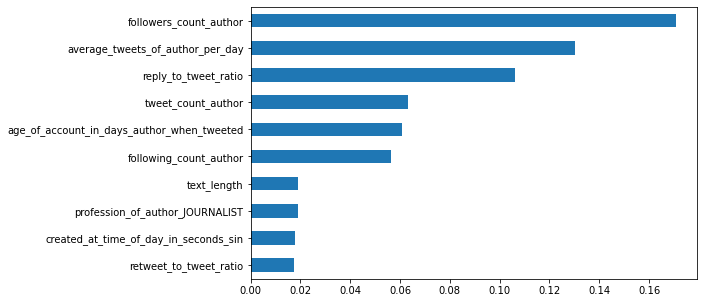

In [ ]:
plt.figure(figsize=(8, 5))
feat.tail(10).plot.barh()